## Imports

In [1]:
import glob
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from PIL import Image, ImageDraw
import random
import tensorflow as tf
from tensorflow.keras import backend as K
import yaml

## Parameters

In [2]:
epochs = 100
batchSize = 512

# Path to images directory. Inside this folder, create circs and nocircs folders.
dataDir = '//home//user//path//to//images//'

imageFormat = 'png'
labelFormat = 'yaml'
numImages = 2000 # of each image type, circs and nocircs
roiSize = 64
valFrac = 0.1
testFrac = 0.2

## Create Data

In [3]:
for i in range(numImages):
    im = Image.new('L', (roiSize, roiSize))
    draw = ImageDraw.Draw(im)
    x = random.randint(0, roiSize)
    y = random.randint(0, roiSize)
    d = random.randint(2, roiSize / 2)
    draw.ellipse((x-d/2, y-d/2, x+d/2, y+d/2), fill=255)
    imageName = 'img{}'.format(i)
    im.save('{}{}.{}'.format(dataDir + 'circs//', imageName, imageFormat))
    with open('{}{}.{}'.format(dataDir + 'circs//', imageName, labelFormat), 'w') as labelFile:
        data = {
            'img': '{}{}.{}'.format(dataDir + 'circs//', imageName, imageFormat),
            'x': float(x/roiSize), # X Center
            'y': float(y/roiSize), # Y Center
            'd': float(d/roiSize), # Diameter
            'c': float(1.0)        # Certainty of circle in image
        }
        yaml.dump(data, labelFile)

    draw.rectangle([x-d/2, y-d/2, x+d/2, y+d/2], fill=255)
    imageName = 'img{}'.format(i)
    im.save('{}{}.{}'.format(dataDir + 'nocircs//', imageName, imageFormat))
    with open('{}{}.{}'.format(dataDir + 'nocircs//', imageName, labelFormat), 'w') as labelFile:
        data = {
            'img': '{}{}.{}'.format(dataDir + 'nocircs//', imageName, imageFormat),
            'x': float(x/roiSize),
            'y': float(y/roiSize),
            'd': float(d/roiSize),
            'c': float(0.0)
        }
        yaml.dump(data, labelFile)

## Load Data Functions

In [4]:
def getAllImageNames(allLabels):
    allImageNames = []
    for label in allLabels:
        allImageNames.append(label['img'])
    return allImageNames

def getAllImagesAsNumpyArray(allImageNames):
    X = np.zeros(shape=(numLabels, roiSize, roiSize)).astype(float)
    for i, imageName in enumerate(allImageNames):
        im = Image.open(imageName)
        X[i] = np.asarray(im)
    return X

def getAllLabels(allLabelNames):
    allLabels = []
    for i, labelName in enumerate(allLabelNames):
        allLabels.append(yamlLoader(labelName))
    return allLabels

def getAllLabelNames():
    os.chdir(dataDir + 'circs//')
    allLabelNames = glob.glob('*.{}'.format(labelFormat))
    theseLabelNames = []
    for i, labelName in enumerate(allLabelNames):
        theseLabelNames.append(dataDir + 'circs//' + labelName)
        theseLabelNames.append(dataDir + 'nocircs//' + labelName)
    return theseLabelNames

def labelsNumpyArray(allLabels):
    Y = np.zeros(shape=(numLabels, 4)).astype(float)
    for i, data in enumerate(allLabels):
        Y[i][0] = data['x']
        Y[i][1] = data['y']
        Y[i][2] = data['d']
        Y[i][3] = data['c']
    return Y

def yamlLoader(filePath):
    os.chdir(dataDir)
    with open(filePath, 'r') as f:
        data = yaml.load(f, Loader=yaml.SafeLoader)
    return data


## Load Data

In [6]:
# Get Labels
allLabelNames = getAllLabelNames()
random.shuffle(allLabelNames)
numLabels = len(allLabelNames)
allLabels = getAllLabels(allLabelNames)
Y = labelsNumpyArray(allLabels)

# Get Images
allImageNames = getAllImageNames(allLabels)
X = getAllImagesAsNumpyArray(allImageNames)

# Split Test Data
test_valid_delimeter = int(numLabels * testFrac)
X_test = X[0:test_valid_delimeter,:,:]
X_test = X_test / 255.0
X_test = tf.convert_to_tensor(X_test, np.float32)
X_test = tf.expand_dims(X_test, axis=-1)
Y_test = Y[0:test_valid_delimeter]
Y_test = tf.convert_to_tensor(Y_test, np.float32)

# Split Validation Data
valid_train_delimeter = test_valid_delimeter + int(numLabels * valFrac)
X_validation = X[test_valid_delimeter:valid_train_delimeter, :, :]
X_validation = X_validation / 255.0
X_validation = tf.convert_to_tensor(X_validation, np.float32)
X_validation = tf.expand_dims(X_validation, axis=-1)
Y_validation = Y[test_valid_delimeter:valid_train_delimeter]
Y_validation = tf.convert_to_tensor(Y_validation, np.float32)

# Split Train Data
X_train = X[valid_train_delimeter:numLabels, :, :]
X_train = X_train / 255.0
X_train = tf.convert_to_tensor(X_train, np.float32)
X_train = tf.expand_dims(X_train, axis=-1)
Y_train = Y[valid_train_delimeter:numLabels]
Y_train = tf.convert_to_tensor(Y_train, np.float32)

print('X_train shape = {}'.format(X_train.shape))
print('Y_train shape = {}'.format(Y_train.shape))

X_train shape = (2800, 64, 64, 1)
Y_train shape = (2800, 4)


## Train

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        input_shape=(roiSize, roiSize, 1),
        filters=8,
        kernel_size=3,
        padding='same'),
    tf.keras.layers.Conv2D(
        filters=8,
        kernel_size=3,
        padding='same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation='relu')
    ])
loss_fn = tf.keras.losses.MeanSquaredError()
model.compile(optimizer='adam', loss=loss_fn, metrics=['mse'])
history = model.fit(X_train,
                    Y_train,
                    epochs=epochs,
                    batch_size=batchSize,
                    validation_data=(X_validation, Y_validation)
                    )

Epoch 1/100


2022-11-14 20:55:09.907851: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-11-14 20:55:11.734983: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


6/6 [==============================] - 4s 90ms/step - loss: 0.1996 - mse: 0.1996 - val_loss: 0.1023 - val_mse: 0.1023
Epoch 2/100
6/6 [==============================] - 0s 21ms/step - loss: 0.1042 - mse: 0.1042 - val_loss: 0.0908 - val_mse: 0.0908
Epoch 3/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0871 - mse: 0.0871 - val_loss: 0.0698 - val_mse: 0.0698
Epoch 4/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0739 - mse: 0.0739 - val_loss: 0.0597 - val_mse: 0.0597
Epoch 5/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0640 - mse: 0.0640 - val_loss: 0.0557 - val_mse: 0.0557
Epoch 6/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0599 - mse: 0.0599 - val_loss: 0.0497 - val_mse: 0.0497
Epoch 7/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0540 - mse: 0.0540 - val_loss: 0.0457 - val_mse: 0.0457
Epoch 8/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0483 - mse: 0.0483 - val_los

Epoch 64/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 65/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 66/100
6/6 [==============================] - 0s 21ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 67/100
6/6 [==============================] - 0s 24ms/step - loss: 0.0108 - mse: 0.0108 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 68/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 69/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 70/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 71/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0104 - m

In [8]:
model.evaluate(X_test, Y_test, verbose=2)

25/25 - 0s - loss: 0.0107 - mse: 0.0107 - 217ms/epoch - 9ms/step


[0.010707162320613861, 0.010707162320613861]

## Plot History

<AxesSubplot:>

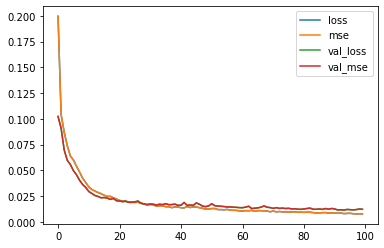

In [9]:
pd.DataFrame(history.history).plot()

## Test Data True Vs Predicted

Actual [0.40625 0.625   0.375   1.     ]
PRED   [0.40193892 0.63289493 0.4101773  0.9457199 ]


Text(0.5, 1.0, 'Predicted')

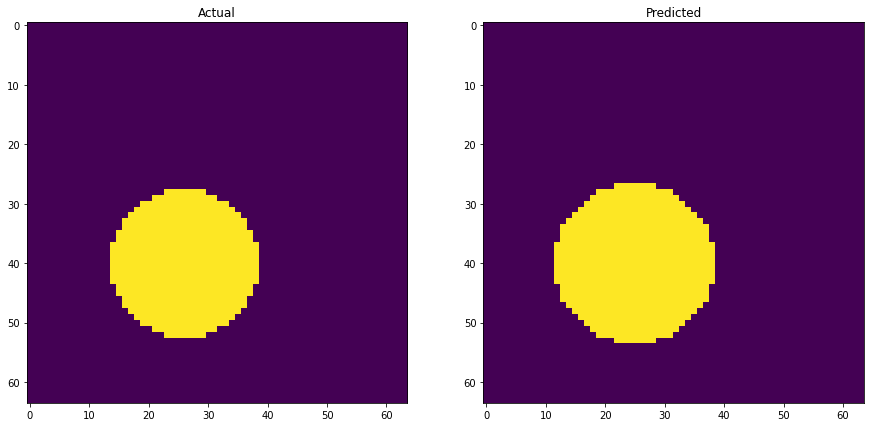

In [10]:
idx = 10
x = tf.expand_dims(X_test[idx], axis=0)
pred = model.predict(x)
print('Actual {}'.format(Y_test[idx]))
print('PRED   {}'.format(pred[0]))

im = Image.new('L', (roiSize, roiSize))
draw = ImageDraw.Draw(im)
x = int(pred[0][0] * roiSize)
y = int(pred[0][1] * roiSize)
d = int(pred[0][2] * roiSize)
draw.ellipse((x-d/2, y-d/2, x+d/2, y+d/2), fill=255)
predImg = np.asarray(im)

f, axarr = plt.subplots(1, 2, figsize=(15, 15))
axarr[0].imshow(X_test[idx])
axarr[0].set_title('Actual')
axarr[1].imshow(im)
axarr[1].set_title('Predicted')

## Test With Rounded Squares

Actual [0.421875, 0.46875, 0.453125, 0.35714285714285715]
PRED   [0.36776528 0.39384112 0.39128733 0.        ]


Text(0.5, 1.0, 'Predicted')

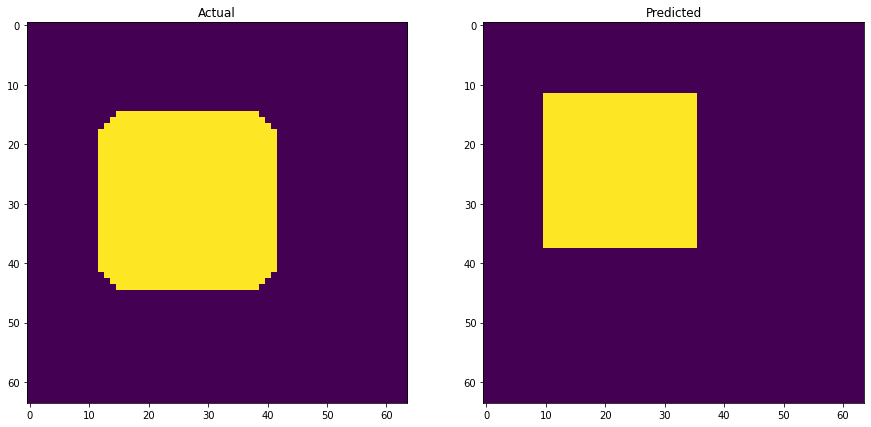

In [13]:
x = random.randint(20,30)
y = random.randint(20, 30)
d = random.randint(20, 30)
maxRad = math.floor(d/2)
r = random.randint(0, maxRad)

im = Image.new('L', (roiSize, roiSize))
draw = ImageDraw.Draw(im)
draw.rounded_rectangle([x-d/2, y-d/2, x+d/2, y+d/2], radius=r, fill=255)

tX = []
tX.append(np.asarray(im))
tX = np.asarray(tX)

tX = tX / 255.0
tX = tf.convert_to_tensor(tX, np.float32)
tX = tf.expand_dims(tX, axis=-1)
actual = [x/roiSize, y/roiSize, d/roiSize, r/maxRad]
pred = model.predict(tX)
print('Actual {}'.format(actual))
print('PRED   {}'.format(pred[0]))

im = Image.new('L', (roiSize, roiSize))
draw = ImageDraw.Draw(im)
x = int(pred[0][0] * roiSize)
y = int(pred[0][1] * roiSize)
d = int(pred[0][2] * roiSize)
if pred[0][3] > 0.5:
    draw.ellipse((x-d/2, y-d/2, x+d/2, y+d/2), fill=255)
else:
    draw.rectangle([x-d/2, y-d/2, x+d/2, y+d/2], fill=255)
predImg = np.asarray(im)

f, axarr = plt.subplots(1, 2, figsize=(15, 15))
axarr[0].imshow(tX[0])
axarr[0].set_title('Actual')
axarr[1].imshow(im)
axarr[1].set_title('Predicted')